## 1. Import Libraries

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.pipeline import Pipeline,FeatureUnion
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

## 2. Display Setting

In [7]:
pd.set_option("display.max_columns",None)

In [8]:
sklearn.set_config(transform_output='pandas')

## 3. Read the Data

In [11]:
path = r"C:\Users\lenovo\Flight price\data\train.csv"
train = pd.read_csv(path)

In [12]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,No Info,8040
1,Multiple Carriers,2019-06-06,Delhi,Cochin,11:25:00,19:00:00,455,1.0,No Info,10877
2,Jet Airways,2019-06-06,Banglore,Delhi,11:10:00,14:05:00,175,0.0,No Info,8016
3,Jet Airways,2019-03-21,Banglore,New Delhi,09:45:00,15:55:00,370,1.0,In-flight meal not included,7280
4,Jet Airways,2019-06-12,Kolkata,Banglore,06:30:00,12:00:00,330,1.0,In-flight meal not included,9899
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-05-21,Delhi,Cochin,11:25:00,19:00:00,455,1.0,No Info,9103
636,Air India,2019-06-09,Kolkata,Banglore,12:00:00,13:15:00,1515,1.0,No Info,7662
637,Jet Airways,2019-03-12,Banglore,New Delhi,05:45:00,23:00:00,1035,1.0,No Info,13817
638,Air India,2019-06-12,Kolkata,Banglore,10:00:00,13:45:00,1665,2.0,No Info,12224


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [15]:
X_train = train.drop(columns='price')
y_train = train.price.copy()

## 4. Tranformation Operations

### 4.1 airline

In [19]:
X_train.airline

0            Jet Airways
1      Multiple Carriers
2            Jet Airways
3            Jet Airways
4            Jet Airways
             ...        
635    Multiple Carriers
636            Air India
637          Jet Airways
638            Air India
639            Air India
Name: airline, Length: 640, dtype: object

In [28]:
air_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])
air_transformer.fit_transform(X_train.loc[:,['airline']])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,1.0,0.0,0.0,0.0,0.0


### 4.2 date_of_journey

In [33]:
train.date_of_journey

0      2019-06-21
1      2019-06-06
2      2019-06-06
3      2019-03-21
4      2019-06-12
          ...    
635    2019-05-21
636    2019-06-09
637    2019-03-12
638    2019-06-12
639    2019-03-12
Name: date_of_journey, Length: 640, dtype: object

In [38]:
feature_to_extract = ['month','week','day_of_week','day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format='mixed')),
    ('scaler',MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.941176,0.666667,0.949153
1,1.000000,0.823529,0.500000,0.822034
2,1.000000,0.823529,0.500000,0.822034
3,0.000000,0.176471,0.500000,0.169492
4,1.000000,0.882353,0.333333,0.872881
...,...,...,...,...
635,0.666667,0.705882,0.166667,0.686441
636,1.000000,0.823529,1.000000,0.847458
637,0.000000,0.117647,0.166667,0.093220
638,1.000000,0.882353,0.333333,0.872881


### 4.3 Source and Destination

In [40]:
X_train.source

0        Mumbai
1         Delhi
2      Banglore
3      Banglore
4       Kolkata
         ...   
635       Delhi
636     Kolkata
637    Banglore
638     Kolkata
639      Mumbai
Name: source, Length: 640, dtype: object

In [41]:
X_train.destination

0      Hyderabad
1         Cochin
2          Delhi
3      New Delhi
4       Banglore
         ...    
635       Cochin
636     Banglore
637    New Delhi
638     Banglore
639    Hyderabad
Name: destination, Length: 640, dtype: object

In [44]:
location_subset = X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Mumbai,Hyderabad
1,Delhi,Cochin
2,Banglore,Delhi
3,Banglore,New Delhi
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Kolkata,Banglore
637,Banglore,New Delhi
638,Kolkata,Banglore


In [48]:
location_pipe1 = Pipeline(steps=[
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
    ('encoder',MeanEncoder()),
    ('scaler',PowerTransformer())
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,-1.809032,-1.187495
1,0.913753,0.914932
2,-1.269872,-1.778655
3,-1.269872,-1.187495
4,0.128521,0.117440
...,...,...
635,0.913753,0.914932
636,0.128521,0.117440
637,-1.269872,-1.187495
638,0.128521,0.117440


In [49]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [54]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi','Kolkata','Mumbai','New Delhi']
    return (
        X
        .assign(**{
            f"{col}_is_north":X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,1,0


In [57]:
location_transformer = FeatureUnion(transformer_list=[
    ('part1',location_pipe1),
    ('part2',FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-1.809032,-1.187495,1,0
1,0.913753,0.914932,1,0
2,-1.269872,-1.778655,0,1
3,-1.269872,-1.187495,0,1
4,0.128521,0.117440,1,0
...,...,...,...,...
635,0.913753,0.914932,1,0
636,0.128521,0.117440,1,0
637,-1.269872,-1.187495,0,1
638,0.128521,0.117440,1,0


### 4.4 Dep_time and arrival_time

In [59]:
time_subset = X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,10:20:00,11:50:00
1,11:25:00,19:00:00
2,11:10:00,14:05:00
3,09:45:00,15:55:00
4,06:30:00,12:00:00
...,...,...
635,11:25:00,19:00:00
636,12:00:00,13:15:00
637,05:45:00,23:00:00
638,10:00:00,13:45:00


In [62]:
time_pipe1 = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.434783,0.363636,0.478261,0.909091
1,0.478261,0.454545,0.826087,0.000000
2,0.478261,0.181818,0.608696,0.090909
3,0.391304,0.818182,0.652174,1.000000
4,0.260870,0.545455,0.521739,0.000000
...,...,...,...,...
635,0.478261,0.454545,0.826087,0.000000
636,0.521739,0.000000,0.565217,0.272727
637,0.217391,0.818182,1.000000,0.000000
638,0.434783,0.000000,0.565217,0.818182


In [64]:
def part_of_day(X,morning=4,noon=12,eve=16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col:pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day":np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive='left'),
                 X_temp.loc[:,col].between(noon,eve,inclusive='left'),
                 X_temp.loc[:,col].between(eve,night,inclusive='left')],
                ['morning','afternoon','evening'],
                default='night'
            )  
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,evening
2,morning,afternoon
3,morning,afternoon
4,morning,afternoon
...,...,...
635,morning,evening
636,afternoon,afternoon
637,morning,night
638,morning,afternoon


In [68]:
time_pipe2 = Pipeline(steps=[
    ('part',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,1.000000
1,1.000000,0.744681
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
635,1.000000,0.744681
636,0.000000,0.000000
637,1.000000,0.808511
638,1.000000,0.000000


In [69]:
time_transformer = FeatureUnion(transformer_list=[
    ('part1',time_pipe1),
    ('part2',time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.434783,0.363636,0.478261,0.909091,1.000000,1.000000
1,0.478261,0.454545,0.826087,0.000000,1.000000,0.744681
2,0.478261,0.181818,0.608696,0.090909,1.000000,0.000000
3,0.391304,0.818182,0.652174,1.000000,1.000000,0.000000
4,0.260870,0.545455,0.521739,0.000000,1.000000,0.000000
...,...,...,...,...,...,...
635,0.478261,0.454545,0.826087,0.000000,1.000000,0.744681
636,0.521739,0.000000,0.565217,0.272727,0.000000,0.000000
637,0.217391,0.818182,1.000000,0.000000,1.000000,0.808511
638,0.434783,0.000000,0.565217,0.818182,1.000000,0.000000


### 4.5 Duration

In [71]:
X_train.duration

0        90
1       455
2       175
3       370
4       330
       ... 
635     455
636    1515
637    1035
638    1665
639     795
Name: duration, Length: 640, dtype: int64

In [85]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    #.shape
)

array([[ 175.],
       [ 515.],
       [1010.]])

In [99]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables=variables
        self.percentiles = percentiles
        self.gamma=gamma
        
    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()
            
        self.reference_values_ = {
            col:(
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
            
        }
        
        return self
    def transform(self,X):
        objects=[]
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data= rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects,axis=1)
        

In [101]:
RBFPercentileSimilarity().fit_transform(X_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,1.668157e-314,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837
1,0.000000e+00,4.508027e-157,0.000000e+00,0.904837,1.000000,1.000000
2,1.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.904837,0.904837
3,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
...,...,...,...,...,...,...
635,0.000000e+00,4.508027e-157,0.000000e+00,0.904837,1.000000,1.000000
636,0.000000e+00,0.000000e+00,0.000000e+00,0.904837,1.000000,1.000000
637,0.000000e+00,0.000000e+00,7.187782e-28,0.904837,1.000000,1.000000
638,0.000000e+00,0.000000e+00,0.000000e+00,0.670320,0.904837,0.904837


In [104]:
duration_pipe1 = Pipeline(steps=[
    ('rbf',RBFPercentileSimilarity()),
    ('scaler',PowerTransformer())
])
duration_union = FeatureUnion(transformer_list=[
    ('part1',duration_pipe1),
    ('part2',StandardScaler())
])
duration_transformer = Pipeline(steps=[
    ('outlier',Winsorizer(capping_method='iqr',fold=1.5)),
    ('imputer',SimpleImputer(strategy='median')),
    ('union',duration_union)
])
duration_transformer.fit_transform(X_train.loc[:,['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.324522,-0.105403,-0.097484,-1.125398
1,-0.324522,-0.105403,-0.097484,-0.404664
2,3.282519,-0.105403,-0.097484,-0.957556
3,-0.324522,-0.105403,-0.097484,-0.572506
4,-0.324522,-0.105403,-0.097484,-0.651491
...,...,...,...,...
635,-0.324522,-0.105403,-0.097484,-0.404664
636,-0.324522,-0.105403,-0.097484,1.688425
637,-0.324522,-0.105403,-0.097484,0.740611
638,-0.324522,-0.105403,-0.097484,1.984616


## 4.6 total_stops

In [106]:
X_train.total_stops

0      0.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
635    1.0
636    1.0
637    1.0
638    2.0
639    2.0
Name: total_stops, Length: 640, dtype: float64

In [107]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ("",FunctionTransformer(func=is_direct))
])
total_stops_transformer.fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,2.0,0


## 4.7 additional_info

In [109]:
X_train.additional_info

0                          No Info
1                          No Info
2                          No Info
3      In-flight meal not included
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [110]:
info_pipe1 = Pipeline(steps = [
    ('group',RareLabelEncoder(tol=0.1,n_categories=2,replace_with='other')),
    ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])
info_pipe1.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [111]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [112]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [113]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

In [114]:
info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,1
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


### 5. Column Transformer

In [115]:
column_transformer = ColumnTransformer(transformers=[
    ('air',air_transformer,['airline']),
    ('doj',doj_transformer,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('dur',duration_transformer,['duration']),
    ('stops',total_stops_transformer,['total_stops']),
    ('info',info_transformer,['additional_info'])
],remainder='passthrough')

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-1.809032,-1.187495,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,1.000000,-0.324522,-0.105403,-0.097484,-1.125398,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,1.000000,0.823529,0.500000,0.822034,0.913753,0.914932,1,0,0.478261,0.454545,0.826087,0.000000,1.000000,0.744681,-0.324522,-0.105403,-0.097484,-0.404664,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-1.269872,-1.778655,0,1,0.478261,0.181818,0.608696,0.090909,1.000000,0.000000,3.282519,-0.105403,-0.097484,-0.957556,0.0,1,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-1.269872,-1.187495,0,1,0.391304,0.818182,0.652174,1.000000,1.000000,0.000000,-0.324522,-0.105403,-0.097484,-0.572506,1.0,0,1.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,0.128521,0.117440,1,0,0.260870,0.545455,0.521739,0.000000,1.000000,0.000000,-0.324522,-0.105403,-0.097484,-0.651491,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,1.0,0.0,0.666667,0.705882,0.166667,0.686441,0.913753,0.914932,1,0,0.478261,0.454545,0.826087,0.000000,1.000000,0.744681,-0.324522,-0.105403,-0.097484,-0.404664,1.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,0.128521,0.117440,1,0,0.521739,0.000000,0.565217,0.272727,0.000000,0.000000,-0.324522,-0.105403,-0.097484,1.688425,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-1.269872,-1.187495,0,1,0.217391,0.818182,1.000000,0.000000,1.000000,0.808511,-0.324522,-0.105403,-0.097484,0.740611,1.0,0,0.0,1.0,0.0,0
638,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,0.128521,0.117440,1,0,0.434783,0.000000,0.565217,0.818182,1.000000,0.000000,-0.324522,-0.105403,-0.097484,1.984616,2.0,0,0.0,1.0,0.0,0


## 6. Feature Selection

In [118]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Putting it all Together

In [119]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.0,0.949153,-1.809032,-1.187495,-0.324522,-1.125398,0.0,1
1,0.0,0.0,0.0,0.822034,0.913753,0.914932,-0.324522,-0.404664,1.0,0
2,0.0,1.0,0.0,0.822034,-1.269872,-1.778655,3.282519,-0.957556,0.0,1
3,0.0,1.0,0.0,0.169492,-1.269872,-1.187495,-0.324522,-0.572506,1.0,0
4,0.0,1.0,0.0,0.872881,0.128521,0.117440,-0.324522,-0.651491,1.0,0
...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.686441,0.913753,0.914932,-0.324522,-0.404664,1.0,0
636,0.0,0.0,0.0,0.847458,0.128521,0.117440,-0.324522,1.688425,1.0,0
637,0.0,1.0,0.0,0.093220,-1.269872,-1.187495,-0.324522,0.740611,1.0,0
638,0.0,0.0,0.0,0.872881,0.128521,0.117440,-0.324522,1.984616,2.0,0


## 8. Visualizations

In [120]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.007183159399962095,
 'air__airline_Indigo': 0.13990543335682504,
 'air__airline_Jet Airways': 0.1562463686824164,
 'air__airline_Multiple Carriers': 0.01154665758854915,
 'air__airline_other': 0.11092791815059255,
 'doj__date_of_journey_month': 0.05767285515503603,
 'doj__date_of_journey_week': 0.08276574180825129,
 'doj__date_of_journey_day_of_week': -0.03683874006414145,
 'doj__date_of_journey_day_of_year': 0.10464214516885306,
 'location__source': 0.18347385467549318,
 'location__destination': 0.1826270398124936,
 'location__source_is_north': 0.0698826841157844,
 'location__destination_is_north': 0.0698826841157844,
 'time__dep_time_hour': -0.017321948304625117,
 'time__dep_time_minute': 0.04005837166554486,
 'time__arrival_time_hour': 0.07124504193124222,
 'time__arrival_time_minute': 0.03866368312932585,
 'time__dep_time_part_of_day': -0.0007591581769700687,
 'time__arrival_time_part_of_day': -0.0036336505136803643,
 'dur__duration_rbf_25': 0.122836537

In [121]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': -0.03683874006414145,
 'time__dep_time_hour': -0.017321948304625117,
 'dur__duration_rbf_50': -0.013104714465155784,
 'time__arrival_time_part_of_day': -0.0036336505136803643,
 'dur__duration_rbf_75': -0.0015878968249674053,
 'time__dep_time_part_of_day': -0.0007591581769700687,
 'info__additional_info_In-flight meal not included': -0.0007540507001147686,
 'info__additional_info_No Info': 0.0014881777995596017,
 'info__additional_info': 0.0014881777995596017,
 'air__airline_Air India': 0.007183159399962095,
 'air__airline_Multiple Carriers': 0.01154665758854915,
 'info__additional_info_other': 0.024570958815236337,
 'time__arrival_time_minute': 0.03866368312932585,
 'time__dep_time_minute': 0.04005837166554486,
 'doj__date_of_journey_month': 0.05767285515503603,
 'location__source_is_north': 0.0698826841157844,
 'location__destination_is_north': 0.0698826841157844,
 'time__arrival_time_hour': 0.07124504193124222,
 'doj__date_of_journey_week': 0.0827

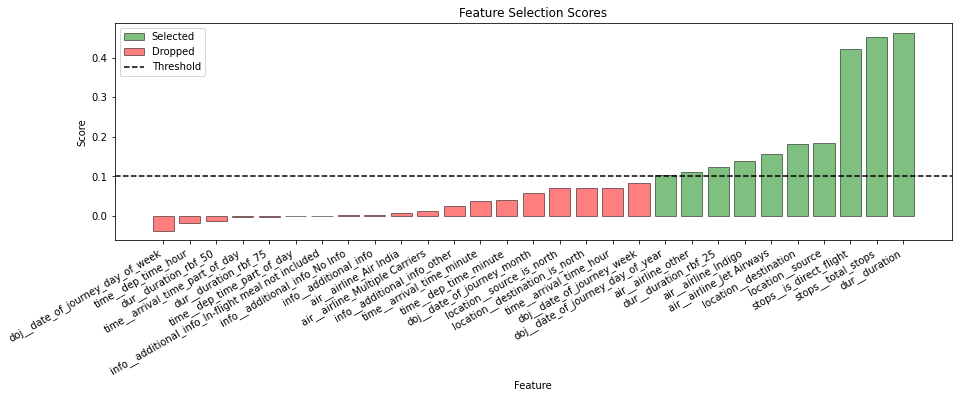

In [124]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()


- The dataset went upto 29 columns after Feature Engineering
- The Feature Selection algorithm selected 10 features out of that

In [18]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']